In [1]:
import torch
import torch.nn as nn
import numpy as np
from scipy.io import loadmat
from tqdm import tqdm
from pyDOE import lhs
import torch.optim as optim

In [ ]:
# !git clone https://github.com/broccubali/NoisyICML.git

Cloning into 'NoisyICML'...
remote: Enumerating objects: 320, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 320 (delta 49), reused 64 (delta 16), pack-reused 202 (from 1)
Receiving objects: 100% (320/320), 88.75 MiB | 32.71 MiB/s, done.
Resolving deltas: 100% (142/142), done.


In [137]:
# again.
import torch.nn.init as init
class PINN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList(
            [
                nn.Linear(input_size if i == 0 else hidden_size, hidden_size)
                if i % 2 == 0
                else nn.SiLU()
                for i in range(10)
            ]
        )
        self.layers.append(nn.Linear(hidden_size, output_size))
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                init.xavier_normal_(layer.weight)  # Initialize weights
                if layer.bias is not None:  # Initialize biases to zero
                    init.zeros_(layer.bias)

        # Trainable parameter for the wave number squared (k^2)
        self.k = nn.Parameter(torch.tensor([5], dtype=torch.float32, device="cuda"))

        self.optimizer = optim.Adam(self.parameters(), lr=1e-2)
        self.loss = nn.MSELoss()
        # self.k = 5

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def loss_fn(self, train, u):
        u_pred = self.forward(train)
        return self.loss(u_pred, u)

    def residual_loss(self, train):
        # Physics-informed loss based on the Helmholtz equation
        g = train.clone()
        g.requires_grad = True
        u_pred = self.forward(g)

        # Compute the gradients for second derivatives (u_xx and u_tt)
        u_x = torch.autograd.grad(
            u_pred, g, torch.ones_like(u_pred), create_graph=True, retain_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, g, torch.ones_like(g), create_graph=True
        )[0] # <---- Similar modification to select the second derivative with respect to X

        k2 = (self.k**2) * np.pi**2
        fhat = -k2 * torch.sin(self.k * np.pi * g) 
        residual = u_xx  + ((self.k) * u_pred) - fhat # <---- Also fixed k to k2
        return self.loss(residual, torch.zeros_like(residual))

    def total_loss(self, train, utrain,):
        alpha_female = 0.5
        data_loss = self.loss_fn(train, utrain)  # Match observed data
        physics_loss = self.residual_loss(train)  # Enforce governing equations
        return data_loss, physics_loss, data_loss + physics_loss

    def train_model(self, train, utrain, epochs=100):
        self.train()
        for epoch in tqdm(range(epochs)):
            self.optimizer.zero_grad()
            data_loss, physics_loss, loss = self.total_loss(train, utrain)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=10.0)  # Adjust max_norm if needed
            self.optimizer.step()
            if epoch % 200 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss = {loss.item()}, Data Loss = {data_loss.item()}, Physics Loss = {physics_loss.item()}, k = {self.k.item()}")

In [145]:
x = np.linspace(-1, 1, 1024)
k = 5
u_true = np.sin(k * np.pi * x) 
u_true.shape

(1024,)

In [146]:
from scipy.stats import skewnorm
noise = skewnorm.rvs(a=1, scale=0.2, size=1024)
u_train = u_true + noise

In [151]:
device = "cuda"
X_train = torch.tensor(x, dtype=torch.float32).to(device).unsqueeze(1)
U_train = torch.tensor(u_train, dtype=torch.float32).to(device).unsqueeze(1)
X_train.shape, U_train.shape

(torch.Size([1024, 1]), torch.Size([1024, 1]))

In [148]:
idx = np.random.choice(X_train.shape[0], 512, replace=False)
X_train = X_train[idx]
U_train = U_train[idx]
X_train.shape, U_train.shape

(torch.Size([512, 1]), torch.Size([512, 1]))

In [149]:
model = PINN(input_size=1, hidden_size=20, output_size=1).to(device)
model.train_model(X_train, U_train, epochs=20000)

  0%|          | 47/20000 [00:00<01:26, 230.49it/s]

Epoch 1/20000, Loss = 30415.5546875, Data Loss = 0.5483824610710144, Physics Loss = 30415.005859375


  1%|          | 234/20000 [00:01<01:33, 211.32it/s]

Epoch 201/20000, Loss = 7928.20703125, Data Loss = 45.09920883178711, Physics Loss = 7883.10791015625


  2%|▏         | 421/20000 [00:01<01:30, 216.94it/s]

Epoch 401/20000, Loss = 5444.62890625, Data Loss = 63.27410888671875, Physics Loss = 5381.35498046875


  3%|▎         | 643/20000 [00:03<01:29, 215.95it/s]

Epoch 601/20000, Loss = 1544.885498046875, Data Loss = 97.83383178710938, Physics Loss = 1447.0516357421875


  4%|▍         | 836/20000 [00:03<01:20, 237.30it/s]

Epoch 801/20000, Loss = 619.535400390625, Data Loss = 105.83802795410156, Physics Loss = 513.6973876953125


  5%|▌         | 1044/20000 [00:04<01:28, 214.99it/s]

Epoch 1001/20000, Loss = 481.2346496582031, Data Loss = 46.16176986694336, Physics Loss = 435.0728759765625


  6%|▌         | 1216/20000 [00:05<01:22, 227.44it/s]

Epoch 1201/20000, Loss = 602.7183837890625, Data Loss = 31.944442749023438, Physics Loss = 570.77392578125


  7%|▋         | 1421/20000 [00:06<01:27, 211.67it/s]

Epoch 1401/20000, Loss = 406.2353820800781, Data Loss = 19.93918228149414, Physics Loss = 386.29620361328125


  8%|▊         | 1626/20000 [00:07<01:26, 211.37it/s]

Epoch 1601/20000, Loss = 239.059814453125, Data Loss = 15.23870849609375, Physics Loss = 223.82110595703125


  9%|▉         | 1821/20000 [00:08<01:30, 200.77it/s]

Epoch 1801/20000, Loss = 143.22161865234375, Data Loss = 12.600767135620117, Physics Loss = 130.620849609375


 10%|█         | 2023/20000 [00:09<01:28, 202.75it/s]

Epoch 2001/20000, Loss = 212.42518615722656, Data Loss = 11.632978439331055, Physics Loss = 200.79220581054688


 11%|█         | 2218/20000 [00:10<01:28, 200.56it/s]

Epoch 2201/20000, Loss = 244.1116943359375, Data Loss = 10.685694694519043, Physics Loss = 233.42599487304688


 12%|█▏        | 2441/20000 [00:11<01:20, 218.68it/s]

Epoch 2401/20000, Loss = 194.33624267578125, Data Loss = 9.91470718383789, Physics Loss = 184.42153930664062


 13%|█▎        | 2640/20000 [00:12<01:23, 208.57it/s]

Epoch 2601/20000, Loss = 70.88264465332031, Data Loss = 9.373910903930664, Physics Loss = 61.50873565673828


 14%|█▍        | 2841/20000 [00:13<01:23, 205.59it/s]

Epoch 2801/20000, Loss = 206.3766632080078, Data Loss = 8.665536880493164, Physics Loss = 197.71112060546875


 15%|█▌        | 3044/20000 [00:14<01:15, 224.43it/s]

Epoch 3001/20000, Loss = 121.4084243774414, Data Loss = 7.65915584564209, Physics Loss = 113.749267578125


 16%|█▌        | 3242/20000 [00:15<01:08, 245.56it/s]

Epoch 3201/20000, Loss = 155.33392333984375, Data Loss = 7.780243396759033, Physics Loss = 147.55368041992188


 17%|█▋        | 3440/20000 [00:15<01:13, 224.89it/s]

Epoch 3401/20000, Loss = 141.9626922607422, Data Loss = 7.029402256011963, Physics Loss = 134.93328857421875


 18%|█▊        | 3628/20000 [00:16<01:11, 228.39it/s]

Epoch 3601/20000, Loss = 101.67874908447266, Data Loss = 6.133711814880371, Physics Loss = 95.54503631591797


 19%|█▉        | 3834/20000 [00:17<01:13, 221.14it/s]

Epoch 3801/20000, Loss = 120.26859283447266, Data Loss = 5.229649543762207, Physics Loss = 115.0389404296875


 20%|██        | 4033/20000 [00:18<01:08, 234.30it/s]

Epoch 4001/20000, Loss = 226.3389434814453, Data Loss = 4.108109474182129, Physics Loss = 222.2308349609375


 21%|██        | 4229/20000 [00:19<01:10, 224.06it/s]

Epoch 4201/20000, Loss = 495.3608703613281, Data Loss = 4.437583923339844, Physics Loss = 490.92327880859375


 22%|██▏       | 4441/20000 [00:20<01:11, 217.71it/s]

Epoch 4401/20000, Loss = 60.883975982666016, Data Loss = 4.381840229034424, Physics Loss = 56.50213623046875


 23%|██▎       | 4641/20000 [00:21<01:14, 205.31it/s]

Epoch 4601/20000, Loss = 91.26435852050781, Data Loss = 3.6028027534484863, Physics Loss = 87.66155242919922


 24%|██▍       | 4837/20000 [00:22<01:02, 243.91it/s]

Epoch 4801/20000, Loss = 51.25105285644531, Data Loss = 2.9875755310058594, Physics Loss = 48.26347732543945


 25%|██▌       | 5046/20000 [00:23<01:06, 224.56it/s]

Epoch 5001/20000, Loss = 188.97421264648438, Data Loss = 2.344940662384033, Physics Loss = 186.6292724609375


 26%|██▌       | 5238/20000 [00:23<01:04, 228.65it/s]

Epoch 5201/20000, Loss = 366.0375671386719, Data Loss = 2.340341329574585, Physics Loss = 363.6972351074219


 27%|██▋       | 5430/20000 [00:24<01:03, 229.19it/s]

Epoch 5401/20000, Loss = 466.7425842285156, Data Loss = 2.658489227294922, Physics Loss = 464.0841064453125


 28%|██▊       | 5632/20000 [00:25<01:08, 208.81it/s]

Epoch 5601/20000, Loss = 146.4387664794922, Data Loss = 2.4508001804351807, Physics Loss = 143.9879608154297


 29%|██▉       | 5841/20000 [00:26<01:01, 231.76it/s]

Epoch 5801/20000, Loss = 178.53564453125, Data Loss = 1.7842731475830078, Physics Loss = 176.75137329101562


 30%|███       | 6033/20000 [00:27<00:59, 235.85it/s]

Epoch 6001/20000, Loss = 118.94993591308594, Data Loss = 1.4621080160140991, Physics Loss = 117.48783111572266


 31%|███       | 6242/20000 [00:28<01:03, 218.08it/s]

Epoch 6201/20000, Loss = 100.71589660644531, Data Loss = 1.1835310459136963, Physics Loss = 99.53236389160156


 32%|███▏      | 6427/20000 [00:29<00:58, 233.36it/s]

Epoch 6401/20000, Loss = 80.62857818603516, Data Loss = 0.9557474851608276, Physics Loss = 79.6728286743164


 33%|███▎      | 6642/20000 [00:30<01:01, 218.77it/s]

Epoch 6601/20000, Loss = 41.824195861816406, Data Loss = 0.6622440814971924, Physics Loss = 41.16195297241211


 34%|███▍      | 6827/20000 [00:31<00:56, 231.39it/s]

Epoch 6801/20000, Loss = 165.09750366210938, Data Loss = 0.8299287557601929, Physics Loss = 164.267578125


 35%|███▌      | 7027/20000 [00:32<01:03, 204.05it/s]

Epoch 7001/20000, Loss = 126.21908569335938, Data Loss = 0.6856365203857422, Physics Loss = 125.533447265625


 36%|███▌      | 7241/20000 [00:33<00:56, 227.11it/s]

Epoch 7201/20000, Loss = 155.12498474121094, Data Loss = 1.3252429962158203, Physics Loss = 153.79974365234375


 37%|███▋      | 7435/20000 [00:33<00:54, 231.94it/s]

Epoch 7401/20000, Loss = 369.4864501953125, Data Loss = 0.5781484246253967, Physics Loss = 368.9082946777344


 38%|███▊      | 7639/20000 [00:34<00:57, 215.85it/s]

Epoch 7601/20000, Loss = 290.55096435546875, Data Loss = 0.2236177921295166, Physics Loss = 290.32733154296875


 39%|███▉      | 7839/20000 [00:35<00:56, 215.12it/s]

Epoch 7801/20000, Loss = 49.408206939697266, Data Loss = 0.2806798815727234, Physics Loss = 49.127525329589844


 40%|████      | 8039/20000 [00:36<00:55, 216.76it/s]

Epoch 8001/20000, Loss = 84.34935760498047, Data Loss = 0.34633684158325195, Physics Loss = 84.00302124023438


 41%|████      | 8224/20000 [00:37<00:52, 224.13it/s]

Epoch 8201/20000, Loss = 84.9509048461914, Data Loss = 0.3303329348564148, Physics Loss = 84.62057495117188


 42%|████▏     | 8431/20000 [00:38<00:54, 211.01it/s]

Epoch 8401/20000, Loss = 76.75247955322266, Data Loss = 0.30310794711112976, Physics Loss = 76.44937133789062


 43%|████▎     | 8640/20000 [00:39<00:55, 206.53it/s]

Epoch 8601/20000, Loss = 54.863399505615234, Data Loss = 0.2184186577796936, Physics Loss = 54.644981384277344


 44%|████▍     | 8838/20000 [00:40<00:45, 244.34it/s]

Epoch 8801/20000, Loss = 66.5391616821289, Data Loss = 0.053185831755399704, Physics Loss = 66.48597717285156


 45%|████▌     | 9027/20000 [00:41<00:48, 225.95it/s]

Epoch 9001/20000, Loss = 96.43644714355469, Data Loss = 0.12917748093605042, Physics Loss = 96.30726623535156


 46%|████▌     | 9246/20000 [00:42<00:44, 240.60it/s]

Epoch 9201/20000, Loss = 56.094852447509766, Data Loss = 0.19729672372341156, Physics Loss = 55.89755630493164


 47%|████▋     | 9448/20000 [00:43<00:42, 248.89it/s]

Epoch 9401/20000, Loss = 59.61990737915039, Data Loss = 0.14611651003360748, Physics Loss = 59.47378921508789


 48%|████▊     | 9634/20000 [00:43<00:51, 200.60it/s]

Epoch 9601/20000, Loss = 37.31773376464844, Data Loss = 0.12779021263122559, Physics Loss = 37.189945220947266


 49%|████▉     | 9826/20000 [00:44<00:49, 204.49it/s]

Epoch 9801/20000, Loss = 89.32627868652344, Data Loss = 0.0602409690618515, Physics Loss = 89.26603698730469


 50%|█████     | 10028/20000 [00:45<00:43, 230.54it/s]

Epoch 10001/20000, Loss = 60.469459533691406, Data Loss = 0.0648830458521843, Physics Loss = 60.40457534790039


 51%|█████     | 10237/20000 [00:46<00:45, 215.63it/s]

Epoch 10201/20000, Loss = 56.08433151245117, Data Loss = 0.0673704519867897, Physics Loss = 56.01696014404297


 52%|█████▏    | 10448/20000 [00:47<00:40, 236.13it/s]

Epoch 10401/20000, Loss = 74.6259765625, Data Loss = 0.05436963215470314, Physics Loss = 74.57160949707031


 53%|█████▎    | 10646/20000 [00:48<00:39, 236.28it/s]

Epoch 10601/20000, Loss = 85.09478759765625, Data Loss = 0.14184701442718506, Physics Loss = 84.95294189453125


 54%|█████▍    | 10834/20000 [00:49<00:41, 223.21it/s]

Epoch 10801/20000, Loss = 82.23201751708984, Data Loss = 0.0759517028927803, Physics Loss = 82.15606689453125


 55%|█████▌    | 11023/20000 [00:50<00:38, 232.02it/s]

Epoch 11001/20000, Loss = 60.2752799987793, Data Loss = 0.08409303426742554, Physics Loss = 60.19118881225586


 56%|█████▌    | 11231/20000 [00:51<00:39, 221.28it/s]

Epoch 11201/20000, Loss = 33.47418975830078, Data Loss = 0.052515286952257156, Physics Loss = 33.42167282104492


 57%|█████▋    | 11430/20000 [00:52<00:36, 233.02it/s]

Epoch 11401/20000, Loss = 32.874053955078125, Data Loss = 0.04549606144428253, Physics Loss = 32.828556060791016


 58%|█████▊    | 11644/20000 [00:53<00:36, 226.01it/s]

Epoch 11601/20000, Loss = 47.893028259277344, Data Loss = 0.04134192690253258, Physics Loss = 47.8516845703125


 59%|█████▉    | 11840/20000 [00:54<00:40, 199.82it/s]

Epoch 11801/20000, Loss = 53.99615478515625, Data Loss = 0.036933783441782, Physics Loss = 53.95922088623047


 60%|██████    | 12039/20000 [00:54<00:37, 211.83it/s]

Epoch 12001/20000, Loss = 54.55636215209961, Data Loss = 0.03742440789937973, Physics Loss = 54.51893615722656


 61%|██████    | 12230/20000 [00:55<00:35, 219.20it/s]

Epoch 12201/20000, Loss = 44.975521087646484, Data Loss = 0.0695362389087677, Physics Loss = 44.905982971191406


 62%|██████▏   | 12430/20000 [00:56<00:37, 199.31it/s]

Epoch 12401/20000, Loss = 56.30697250366211, Data Loss = 0.04070159047842026, Physics Loss = 56.26626968383789


 63%|██████▎   | 12626/20000 [00:57<00:35, 208.87it/s]

Epoch 12601/20000, Loss = 59.12596130371094, Data Loss = 0.03938942775130272, Physics Loss = 59.086570739746094


 64%|██████▍   | 12839/20000 [00:58<00:31, 227.10it/s]

Epoch 12801/20000, Loss = 52.65348815917969, Data Loss = 0.038211919367313385, Physics Loss = 52.61527633666992


 65%|██████▌   | 13027/20000 [00:59<00:29, 234.07it/s]

Epoch 13001/20000, Loss = 42.77217102050781, Data Loss = 0.03533355891704559, Physics Loss = 42.736839294433594


 66%|██████▌   | 13231/20000 [01:00<00:36, 187.89it/s]

Epoch 13201/20000, Loss = 51.95501708984375, Data Loss = 0.03678897023200989, Physics Loss = 51.91822814941406


 67%|██████▋   | 13439/20000 [01:01<00:28, 230.87it/s]

Epoch 13401/20000, Loss = 117.12944030761719, Data Loss = 0.039801593869924545, Physics Loss = 117.08963775634766


 68%|██████▊   | 13628/20000 [01:02<00:27, 232.01it/s]

Epoch 13601/20000, Loss = 52.172977447509766, Data Loss = 0.04715798795223236, Physics Loss = 52.12582015991211


 69%|██████▉   | 13835/20000 [01:03<00:31, 196.38it/s]

Epoch 13801/20000, Loss = 113.10771942138672, Data Loss = 0.04714323952794075, Physics Loss = 113.06057739257812


 70%|███████   | 14039/20000 [01:04<00:27, 216.48it/s]

Epoch 14001/20000, Loss = 122.8843002319336, Data Loss = 0.18929298222064972, Physics Loss = 122.69500732421875


 71%|███████   | 14246/20000 [01:05<00:26, 218.50it/s]

Epoch 14201/20000, Loss = 33.84455108642578, Data Loss = 0.07293839007616043, Physics Loss = 33.77161407470703


 72%|███████▏  | 14433/20000 [01:06<00:24, 223.61it/s]

Epoch 14401/20000, Loss = 92.96560668945312, Data Loss = 0.03789544105529785, Physics Loss = 92.9277114868164


 73%|███████▎  | 14641/20000 [01:07<00:23, 232.34it/s]

Epoch 14601/20000, Loss = 47.270687103271484, Data Loss = 0.03449287265539169, Physics Loss = 47.2361946105957


 74%|███████▍  | 14846/20000 [01:07<00:20, 250.49it/s]

Epoch 14801/20000, Loss = 35.707271575927734, Data Loss = 0.03536226227879524, Physics Loss = 35.67190933227539


 75%|███████▌  | 15042/20000 [01:08<00:22, 224.76it/s]

Epoch 15001/20000, Loss = 56.09677505493164, Data Loss = 0.035190120339393616, Physics Loss = 56.06158447265625


 76%|███████▌  | 15237/20000 [01:09<00:23, 200.01it/s]

Epoch 15201/20000, Loss = 76.93853759765625, Data Loss = 0.034216299653053284, Physics Loss = 76.9043197631836


 77%|███████▋  | 15431/20000 [01:10<00:24, 187.63it/s]

Epoch 15401/20000, Loss = 40.39906692504883, Data Loss = 0.03468339517712593, Physics Loss = 40.364383697509766


 78%|███████▊  | 15645/20000 [01:11<00:18, 238.65it/s]

Epoch 15601/20000, Loss = 26.78515625, Data Loss = 0.04109648987650871, Physics Loss = 26.744060516357422


 79%|███████▉  | 15834/20000 [01:12<00:17, 232.21it/s]

Epoch 15801/20000, Loss = 44.63077926635742, Data Loss = 0.03628626465797424, Physics Loss = 44.5944938659668


 80%|████████  | 16043/20000 [01:13<00:17, 223.01it/s]

Epoch 16001/20000, Loss = 40.87469482421875, Data Loss = 0.034666210412979126, Physics Loss = 40.84002685546875


 81%|████████  | 16238/20000 [01:14<00:17, 209.01it/s]

Epoch 16201/20000, Loss = 47.220497131347656, Data Loss = 0.03443522751331329, Physics Loss = 47.18606185913086


 82%|████████▏ | 16433/20000 [01:15<00:17, 204.53it/s]

Epoch 16401/20000, Loss = 32.31821823120117, Data Loss = 0.050258684903383255, Physics Loss = 32.26795959472656


 83%|████████▎ | 16630/20000 [01:16<00:15, 218.62it/s]

Epoch 16601/20000, Loss = 158.60610961914062, Data Loss = 0.1539861559867859, Physics Loss = 158.45211791992188


 84%|████████▍ | 16845/20000 [01:17<00:13, 238.22it/s]

Epoch 16801/20000, Loss = 33.33696746826172, Data Loss = 0.035196445882320404, Physics Loss = 33.3017692565918


 85%|████████▌ | 17038/20000 [01:18<00:13, 222.54it/s]

Epoch 17001/20000, Loss = 36.30634689331055, Data Loss = 0.03934254124760628, Physics Loss = 36.267005920410156


 86%|████████▌ | 17226/20000 [01:18<00:11, 233.62it/s]

Epoch 17201/20000, Loss = 40.17927551269531, Data Loss = 0.037563636898994446, Physics Loss = 40.1417121887207


 87%|████████▋ | 17444/20000 [01:19<00:11, 223.57it/s]

Epoch 17401/20000, Loss = 74.34993743896484, Data Loss = 0.03500386327505112, Physics Loss = 74.31493377685547


 88%|████████▊ | 17643/20000 [01:20<00:11, 206.90it/s]

Epoch 17601/20000, Loss = 624.14013671875, Data Loss = 0.045042943209409714, Physics Loss = 624.0950927734375


 89%|████████▉ | 17830/20000 [01:21<00:10, 202.10it/s]

Epoch 17801/20000, Loss = 18.425010681152344, Data Loss = 0.039776429533958435, Physics Loss = 18.385234832763672


 90%|█████████ | 18039/20000 [01:22<00:08, 236.46it/s]

Epoch 18001/20000, Loss = 52.568233489990234, Data Loss = 0.040860988199710846, Physics Loss = 52.527374267578125


 91%|█████████ | 18223/20000 [01:23<00:08, 213.12it/s]

Epoch 18201/20000, Loss = 44.937625885009766, Data Loss = 0.04229447990655899, Physics Loss = 44.89533233642578


 92%|█████████▏| 18425/20000 [01:24<00:07, 221.92it/s]

Epoch 18401/20000, Loss = 33.64773178100586, Data Loss = 0.03768713399767876, Physics Loss = 33.61004638671875


 93%|█████████▎| 18642/20000 [01:25<00:05, 241.16it/s]

Epoch 18601/20000, Loss = 31.832061767578125, Data Loss = 0.041781485080718994, Physics Loss = 31.790279388427734


 94%|█████████▍| 18827/20000 [01:26<00:05, 219.04it/s]

Epoch 18801/20000, Loss = 30.875051498413086, Data Loss = 0.037848372012376785, Physics Loss = 30.837203979492188


 95%|█████████▌| 19036/20000 [01:27<00:04, 235.07it/s]

Epoch 19001/20000, Loss = 73.0147476196289, Data Loss = 0.0902244970202446, Physics Loss = 72.92452239990234


 96%|█████████▌| 19241/20000 [01:28<00:03, 218.47it/s]

Epoch 19201/20000, Loss = 35.13682174682617, Data Loss = 0.03778589144349098, Physics Loss = 35.099037170410156


 97%|█████████▋| 19429/20000 [01:29<00:02, 223.89it/s]

Epoch 19401/20000, Loss = 26.877485275268555, Data Loss = 0.04145918786525726, Physics Loss = 26.83602523803711


 98%|█████████▊| 19627/20000 [01:30<00:01, 211.06it/s]

Epoch 19601/20000, Loss = 28.910696029663086, Data Loss = 0.04335526004433632, Physics Loss = 28.867340087890625


 99%|█████████▉| 19840/20000 [01:31<00:00, 217.72it/s]

Epoch 19801/20000, Loss = 39.13182067871094, Data Loss = 0.03335397318005562, Physics Loss = 39.09846496582031


100%|██████████| 20000/20000 [01:31<00:00, 217.67it/s]


In [ ]:
import matplotlib.pyplot as plt

with torch.no_grad():
    u_pred = model(train).cpu().numpy()
plt.imshow(u_pred.reshape(101, 101), cmap="viridis")
plt.colorbar()
plt.show()

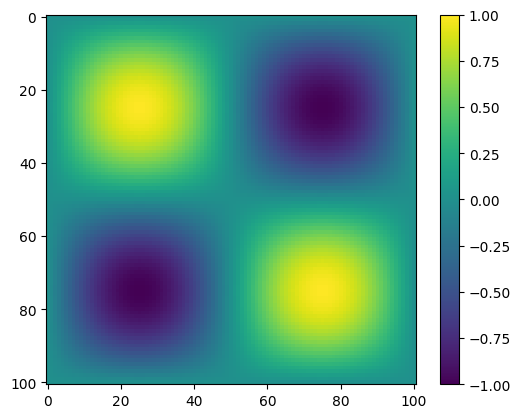

In [45]:
plt.imshow(u_true, cmap="viridis")
plt.colorbar()
plt.show()

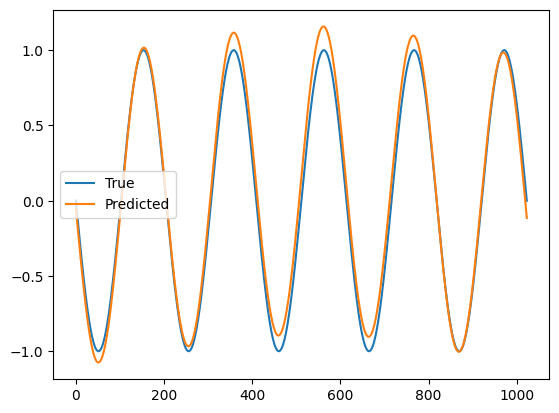

In [153]:
with torch.no_grad():
    u_pred = model(X_train).cpu().numpy()
plt.plot(u_true, label="True")
plt.plot(u_pred, label="Predicted")
# plt.plot(u_train, label="Noisy")
plt.legend()
plt.show()

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from tqdm import tqdm

def visualize_helmholtz(X, Y, data, path):
    """
    Visualizes the 2D Helmholtz solution as an animation.

    Args:
    X, Y : Meshgrid coordinates for plotting
    data : 3D NumPy array [time, X, Y] representing the solution at different times
    path : Path to save the animation
    """
    fig, ax = plt.subplots()

    # Use contour plot or imshow
    im = ax.imshow(data[0], extent=[X.min(), X.max(), Y.min(), Y.max()],
                   origin='lower', cmap='viridis', animated=True)
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_title("Helmholtz Equation Solution Animation")

    def update(frame):
        im.set_array(data[frame])  # Update solution at new time step
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=len(data), interval=50, blit=False)

    writer = animation.PillowWriter(fps=15, bitrate=1800)
    ani.save(path, writer=writer)
    plt.close(fig)

# Example Usage
# Generate example Helmholtz solution data
# x = np.linspace(-1, 1, 100)
# y = np.linspace(-1, 1, 100)
# X, Y = np.meshgrid(x, y)

# # Example 2D Helmholtz wave solution evolving over time
# time_steps = 50
# a1, a2 = 1, 1
# data = np.array([np.sin(a1 * np.pi * X) * np.sin(a2 * np.pi * Y) * np.cos(2 * np.pi * t / time_steps)
#                  for t in range(time_steps)])

# Visualize and save
# visualize_helmholtz(X, Y, data, "helmholtz_solution.gif")

In [13]:
x, y = X_train[:1024], Y_train[:1024]
X, Y = np.meshgrid(x.cpu().numpy(), y.cpu().numpy())
a = torch.stack((x, y), dim=1).to(device)
u = model(a).detach().cpu().nump


y().reshape(32, 32)
u.shape, X.shape, Y.shape

((32, 32), (1024, 1024), (1024, 1024))

In [50]:
# Create 50 time steps by adding small variations (e.g., sine wave modulation)
t = np.linspace(0, 2 * np.pi, 50)
u_time_series = np.array([u_true * np.sin(ti) for ti in t])
# u_time_series = u_time_series[:, :, :]
u_time_series.shape

(50, 101, 101)

In [51]:
visualize_helmholtz(X, Y, u_time_series, "helmholtz_solution.gif")